In [2]:
# Set seeds for reproducibility
import random
random.seed(0)

import numpy as np
np.random.seed(0)

import tensorflow as tf
tf.random.set_seed(0)

In [3]:
import os
import json
from zipfile import ZipFile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetV2B0 # <-- ADD THIS LINE
from tensorflow.keras.optimizers import Adam

In [4]:
!pip install kaggle

In [5]:
kaggle_credentails = json.load(open("kaggle.json"))

In [6]:
os.environ['KAGGLE_USERNAME'] = kaggle_credentails["username"]
os.environ['KAGGLE_KEY'] = kaggle_credentails["key"]

In [7]:
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 99% 2.03G/2.04G [00:23<00:00, 110MB/s]
100% 2.04G/2.04G [00:23<00:00, 93.5MB/s]


In [8]:
!ls

drive  kaggle.json  plantvillage-dataset.zip  sample_data


In [9]:
with ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
  zip_ref.extractall()

In [10]:
print(os.listdir("plantvillage dataset"))


print(len(os.listdir("plantvillage dataset/segmented")))
print(os.listdir("plantvillage dataset/segmented")[:5])

print(len(os.listdir("plantvillage dataset/color")))
print(os.listdir("plantvillage dataset/color")[:5])

print(len(os.listdir("plantvillage dataset/grayscale")))
print(os.listdir("plantvillage dataset/grayscale")[:5])

['color', 'segmented', 'grayscale']
38
['Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Leaf_Mold', 'Grape___healthy']
38
['Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Leaf_Mold', 'Grape___healthy']
38
['Tomato___healthy', 'Grape___Esca_(Black_Measles)', 'Corn_(maize)___Common_rust_', 'Tomato___Leaf_Mold', 'Grape___healthy']


In [11]:
print(len(os.listdir("plantvillage dataset/color/Grape___healthy")))
print(os.listdir("plantvillage dataset/color/Grape___healthy")[:5])

423
['72cd93bf-63f6-476a-b3ae-43af2006c9f2___Mt.N.V_HL 6132.JPG', '7e72db84-6afb-408b-b0de-d1b16e9a48af___Mt.N.V_HL 6050.JPG', '8e026e59-ea04-4f21-832c-b7c4539dfe91___Mt.N.V_HL 6096.JPG', 'a23b47a4-048d-4992-bc61-f3adec202543___Mt.N.V_HL 6113.JPG', '92fbe3df-dc85-4e06-8109-3a14f5109b29___Mt.N.V_HL 6173.JPG']


In [12]:
# Dataset Path
base_dir = 'plantvillage dataset/color'

(256, 256, 3)


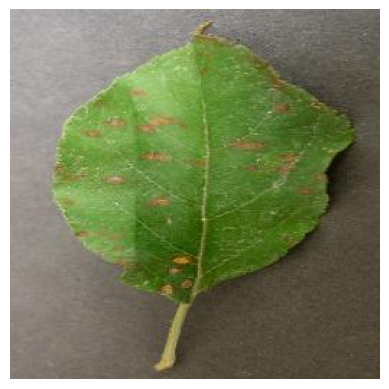

In [13]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img.shape)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [14]:
image_path = '/content/plantvillage dataset/color/Apple___Cedar_apple_rust/025b2b9a-0ec4-4132-96ac-7f2832d0db4a___FREC_C.Rust 3655.JPG'

# Read the image
img = mpimg.imread(image_path)

print(img)

[[[179 175 176]
  [181 177 178]
  [184 180 181]
  ...
  [115 112 105]
  [108 105  98]
  [101  98  91]]

 [[176 172 173]
  [177 173 174]
  [178 174 175]
  ...
  [113 110 103]
  [111 108 101]
  [109 106  99]]

 [[180 176 177]
  [180 176 177]
  [180 176 177]
  ...
  [108 105  98]
  [111 108 101]
  [114 111 104]]

 ...

 [[137 128 119]
  [131 122 113]
  [125 116 107]
  ...
  [ 74  65  48]
  [ 74  65  48]
  [ 73  64  47]]

 [[136 127 118]
  [132 123 114]
  [128 119 110]
  ...
  [ 77  69  50]
  [ 75  67  48]
  [ 75  67  48]]

 [[133 124 115]
  [133 124 115]
  [132 123 114]
  ...
  [ 81  73  54]
  [ 80  72  53]
  [ 79  71  52]]]


In [15]:
# Image dimensions and batch size
img_size = 224
batch_size = 32

In [16]:
# Augmented Data Generator
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [17]:
# Train and Validation Generators
train_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)

Found 43456 images belonging to 38 classes.


In [18]:
validation_generator = data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 10849 images belonging to 38 classes.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,099,110 (91.93 MB)

 Trainable params: 534,310 (2.04 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Starting training with ResNet50V2...
Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 686s 495ms/step - accuracy: 0.7330 - loss: 0.9491 - val_accuracy: 0.9117 - val_loss: 0.2721
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 677s 499ms/step - accuracy: 0.8920 - loss: 0.3310 - val_accuracy: 0.9259 - val_loss: 0.2258
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 671s 494ms/step - accuracy: 0.9120 - loss: 0.2694 - val_accuracy: 0.9328 - val_loss: 0.2031
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 668s 492ms/step - accuracy: 0.9164 - loss: 0.2449 - val_accuracy: 0.9345 - val_loss: 0.1946
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 667s 491ms/step - accuracy: 0.9216 - loss: 0.2340 - val_accuracy: 0.9433 - val_loss: 0.1768
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 682s 502ms/step - accuracy: 0.9285 - loss: 0.2133 - val_accuracy: 0.9444 - val_loss: 0.1670
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 673s 496ms/step - accuracy: 0.9295 - loss: 0.2143 - val_accuracy: 0.9404 - val_loss: 0.1796
Epoch 8/10
1358/1358 ━━━━

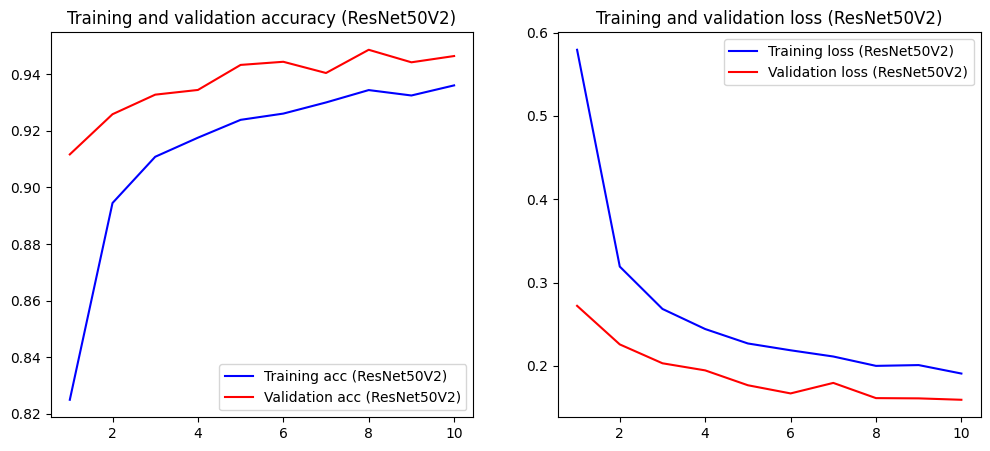

In [20]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers

# 1. Setup the Base Model (ResNet50V2)
# CHANGED: Updated input_shape to (224, 224, 3) to match your data generator
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# 2. Freeze the Base Model
base_model.trainable = False

# 3. Create the Classification Head
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(38, activation='softmax')
])

# 4. Compile the Model
model_resnet.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_resnet.summary()

# 5. Train the Model
print("Starting training with ResNet50V2...")
history_resnet = model_resnet.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# 7. Plotting Code (Optional: To visually compare graphs later)
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label=f'Training acc ({model_name})')
    plt.plot(epochs, val_acc, 'r', label=f'Validation acc ({model_name})')
    plt.title(f'Training and validation accuracy ({model_name})')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label=f'Training loss ({model_name})')
    plt.plot(epochs, val_loss, 'r', label=f'Validation loss ({model_name})')
    plt.title(f'Training and validation loss ({model_name})')
    plt.legend()
    plt.show()

plot_history(history_resnet, "ResNet50V2")

Found 54305 images belonging to 38 classes.
Running predictions...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1698/1698 ━━━━━━━━━━━━━━━━━━━━ 686s 400ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.95      0.96      0.96       630
                                 Apple___Black_rot       0.97      0.98      0.98       621
                          Apple___Cedar_apple_rust       1.00      0.96      0.98       275
                                   Apple___healthy       0.98      0.96      0.97      1645
                               Blueberry___healthy       0.98      1.00      0.99      1502
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      0.99      1052
                 Cherry_(including_sour)___healthy       0.99      0.98      0.99       854
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.78      0.91      0.84       513
                       Corn_(maize)___Common_rust_       0.97      1.00      0.98      1192
        

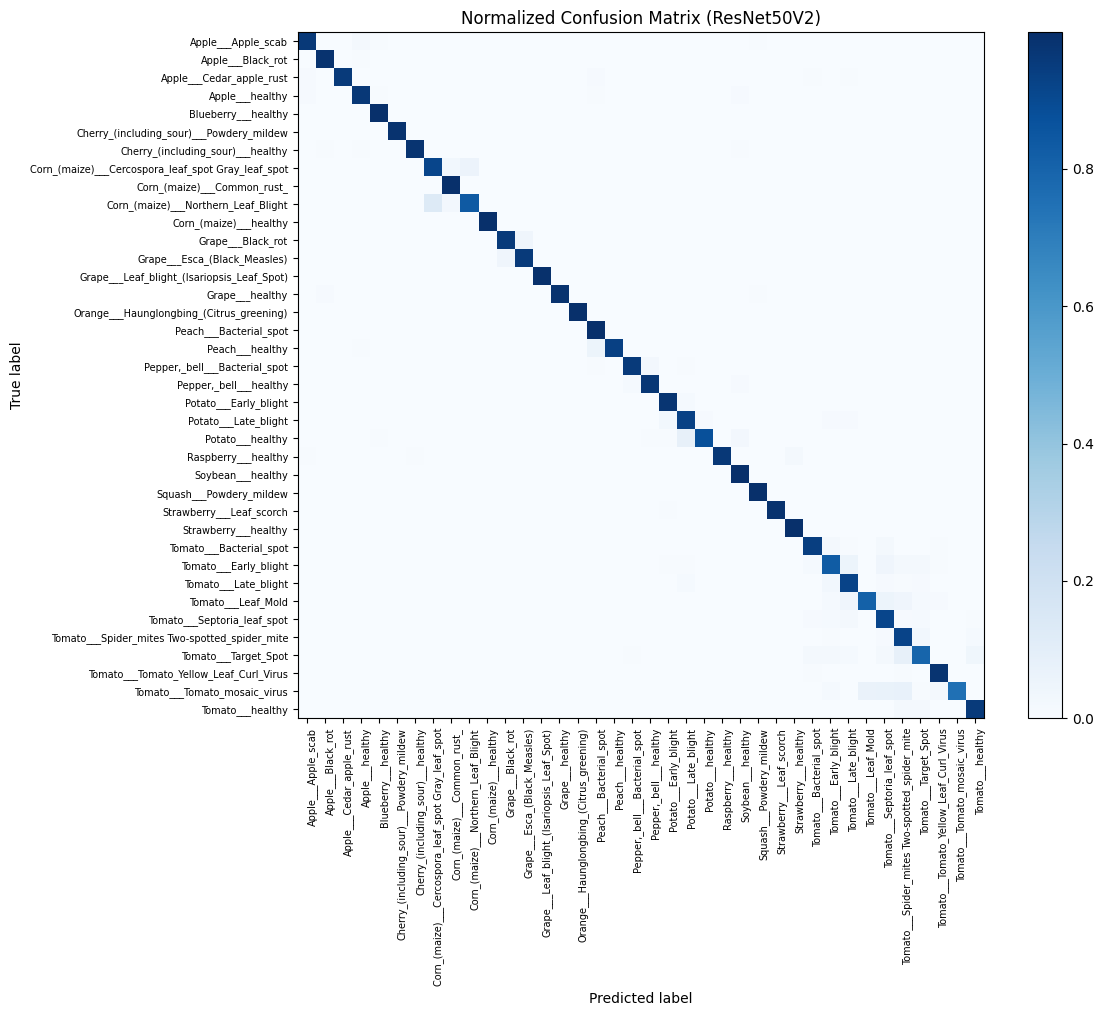

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a NON-SHUFFLED validation generator for evaluation
# We use the same 'data_gen' (ImageDataGenerator) you created earlier
# Note: Ensure target_size matches the ResNet input (224, 224)
val_eval_gen = validation_generator.image_data_generator.flow_from_directory(
    validation_generator.directory, # uses the same directory as your validation_generator
    target_size=(224, 224),       # Matches ResNet input
    batch_size=32,
    class_mode='categorical',
    shuffle=False                 # IMPORTANT: Don't shuffle for confusion matrix
)

# 2. Predictions using 'model_resnet'
print("Running predictions...")
val_eval_gen.reset()
Y_pred = model_resnet.predict(val_eval_gen, verbose=1)

y_pred = np.argmax(Y_pred, axis=1)
y_true = val_eval_gen.classes
class_names = list(val_eval_gen.class_indices.keys())

# 3. Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# 4. Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
# Normalize
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Tick labels
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    xlabel='Predicted label',
    ylabel='True label',
    title='Normalized Confusion Matrix (ResNet50V2)'
)

plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor", fontsize=7)
plt.setp(ax.get_yticklabels(), fontsize=7)

fig.tight_layout()
plt.show()

In [24]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [25]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [32]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [28]:
# 1. Reset the generator to ensure we start from the beginning
val_eval_gen.reset()

# 2. Evaluate the model
print("Evaluating model accuracy...")
loss, accuracy = model_resnet.evaluate(val_eval_gen, verbose=1)

# 3. Print the results clearly
print(f"\n--------------------------------------")
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print(f"Overall Loss:     {loss:.4f}")
print(f"--------------------------------------")

Evaluating model accuracy...
1698/1698 ━━━━━━━━━━━━━━━━━━━━ 673s 396ms/step - accuracy: 0.9696 - loss: 0.0865

--------------------------------------
Overall Accuracy: 96.00%
Overall Loss:     0.1176
--------------------------------------


In [29]:
# Save the ResNet50V2 model
# We use 'model_resnet' because that is the name we gave it during training
model_resnet.save('drive/MyDrive/main_plant/plant_disease_model_ResNet50V2.keras')

print("ResNet50V2 model saved successfully to Drive!")

ResNet50V2 model saved successfully to Drive!


In [30]:
import tensorflow as tf
from PIL import Image
import numpy as np
import io

# --- 1. Get Class Indices from the current generator ---
# We don't need to load a JSON if we have the generator in memory
class_indices = {v: k for k, v in train_generator.class_indices.items()}

# --- 2. Preprocessing Function ---
def preprocess_image(image_bytes: bytes, target_size=(224, 224)) -> np.ndarray:
    """Converts image bytes to a preprocessed numpy array for the model."""
    img = Image.open(io.BytesIO(image_bytes))
    img = img.resize(target_size) # Resizing to 224x224 for ResNet
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    # ResNet50V2 expects inputs in range [-1, 1] or [0, 1] depending on preprocessing.
    # Since we used ResNet50V2 with standard weights, 1./255 scaling (which you likely used in data_gen) is usually fine,
    # but strictly ResNetV2 uses specific preprocessing.
    # For this comparison, keeping 1/255 is okay if your training data was 1/255.
    img_array = img_array.astype('float32') / 255.0
    return img_array

# --- 3. Prediction Function ---
def predict_disease(image_bytes: bytes) -> dict:
    processed_img = preprocess_image(image_bytes)
    # Use 'model_resnet' here
    prediction = model_resnet.predict(processed_img)

    predicted_class_index = np.argmax(prediction, axis=1)[0]
    disease_name = class_indices.get(predicted_class_index, "Unknown Disease")
    confidence = float(np.max(prediction))

    return {"disease_name": disease_name, "confidence": confidence}

# --- 4. RUNNING THE TEST ---
image_path = '/content/plantvillage dataset/grayscale/Apple___Cedar_apple_rust/0340baaa-e9cc-4c04-8f9b-c204180d9ae3___FREC_C.Rust 3805.JPG'

# Read the file as BINARY (bytes)
try:
    with open(image_path, "rb") as image_file:
        image_bytes = image_file.read()

    # Predict
    result = predict_disease(image_bytes)
    print("Result:", result)
except FileNotFoundError:
    print(f"File not found: {image_path}. Please check the path.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Result: {'disease_name': 'Apple___healthy', 'confidence': 0.9934657216072083}
